In [60]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import sklearn
from keras_preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization,Input
from keras.layers import Conv1D, Conv2D, MaxPooling2D,Conv2DTranspose,UpSampling2D
from keras import regularizers, optimizers,Sequential
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
import cv2
import keras
from sklearn.metrics import recall_score
from tensorflow.python.keras import backend as K 
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tqdm import tqdm_notebook
import os


from keras.layers import Dense,GlobalAveragePooling2D
from keras.applications import MobileNet
from keras.preprocessing import image
from keras.applications.mobilenet import preprocess_input
from keras.models import Model
from keras.optimizers import Adam
from keras.applications.vgg16 import VGG16
from keras.applications.inception_resnet_v2 import InceptionResNetV2
#for dirname, _, filenames in os.walk('/kaggle/input'):
#    for filename in filenames:
#        #print(os.path.join(dirname, filename))
#        print(dirname)
# Any results you write to the current directory are saved as output.

In [61]:
os.listdir('/kaggle/')

['lib', 'input', 'config', 'working']

In [62]:
os.listdir('/kaggle/input')

['inceptionresnetv2', 'severstal-steel-defect-detection']

In [63]:
os.listdir('/kaggle/input/severstal-steel-defect-detection')

['train.csv', 'sample_submission.csv', 'train_images', 'test_images']

In [64]:
os.listdir('/kaggle/input/severstal-steel-defect-detection/')
dir1='/kaggle/input/severstal-steel-defect-detection/'

In [65]:
df=pd.read_csv(dir1+'train.csv')

In [66]:
sub=pd.read_csv(dir1+'sample_submission.csv')
sub['imageid']=sub.ImageId_ClassId.apply(lambda x: x.split('_')[0])
sub['class']=sub.ImageId_ClassId.apply(lambda x: int(x.split('_')[1]))
print(sub.shape)
sub.head()


(7204, 4)


,ImageId_ClassId,EncodedPixels,imageid,class
0,004f40c73.jpg_1,1 1,004f40c73.jpg,1
1,004f40c73.jpg_2,1 1,004f40c73.jpg,2
2,004f40c73.jpg_3,1 1,004f40c73.jpg,3
3,004f40c73.jpg_4,1 1,004f40c73.jpg,4
4,006f39c41.jpg_1,1 1,006f39c41.jpg,1


In [67]:
df.fillna(0,inplace=True)
df.head(3)

,ImageId_ClassId,EncodedPixels
0,0002cc93b.jpg_1,29102 12 29346 24 29602 24 29858 24 30114 24 3...
1,0002cc93b.jpg_2,0
2,0002cc93b.jpg_3,0


In [68]:
df['imageid']=df.ImageId_ClassId.apply(lambda x: x.split('_')[0])
df['class']=df.ImageId_ClassId.apply(lambda x: x.split('_')[1])

In [69]:
df.head(3)

,ImageId_ClassId,EncodedPixels,imageid,class
0,0002cc93b.jpg_1,29102 12 29346 24 29602 24 29858 24 30114 24 3...,0002cc93b.jpg,1
1,0002cc93b.jpg_2,0,0002cc93b.jpg,2
2,0002cc93b.jpg_3,0,0002cc93b.jpg,3


In [70]:
count=0
class_list=[]
class_count=[]
multi_class=[]
dummy=[]
m_class=[]
class_1=[]
class_2=[]
class_3=[]
class_4=[]
no_class=[]
for i in range(0,len(df['EncodedPixels']),4):
    for k in range(0+i,4+i):
        if(df['EncodedPixels'][k]!=0):
            count+=1
            dummy.append(int(df['class'][k]))
            pass
        if(k==i+3 and count>=1):
            multi_class.append(dummy)
            class_count=class_count+dummy
            class_list.append(i)
            A=0
            B=0
            C=0
            D=0
            for x in dummy:
                if(x==1):A=1 
                if(x==2):B=1 
                if(x==3):C=1 
                if(x==4):D=1 
                pass
            m_class.append([A,B,C,D])
            if(count==1):
                class_1.append(i)
                pass
            elif(count==2):
                class_2.append(i)
                pass
            elif(count==3):
                class_3.append(i)
                pass
            elif(count==4):
                class_4.append(i)
                pass
            pass
        elif(k==i+3 and count==0):
            no_class.append(i)
            
    count=0
    dummy=[]
    pass


0.5303946530872056 %  of the Images are Defective are
0.46960534691279443 %  of the Images are Non-Defective are


,class_types,class_count
Defect_classes,Defect_class,6666.0
Non_defect_classes,Non_defect_class,5902.0


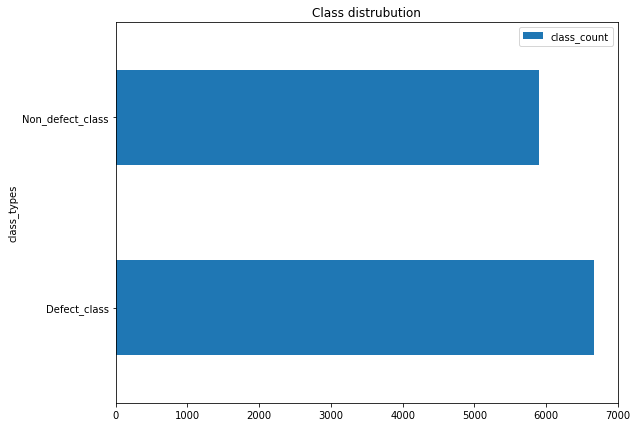

In [71]:
dff=pd.DataFrame({'class_types':['Defect_class','Non_defect_class'],'class_count':[len(class_list),(len(df)/4)-len(class_list)]},index=['Defect_classes','Non_defect_classes'])
dff.plot.barh(x='class_types',y='class_count',figsize=(9,7)).set_title('Class distrubution')

print('='*80)

print(len(class_list)/(len(df)/4),'%  of the Images are Defective are')
print(1-(len(class_list)/(len(df)/4)),'%  of the Images are Non-Defective are')

print('='*80)

dff

--------------------------------------------------------------------------------
Majority class is Class_3 with 4759 Data points
Minority class is Class_2 with 195 Data points


,index,class_count
class_1,class1_Count,769
class_2,class2_Count,195
class_3,class3_Count,4759
class_4,class4_Count,516


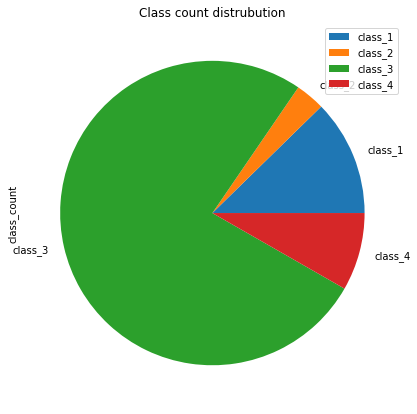

In [72]:
pf=pd.DataFrame({'index':['class1_Count','class2_Count','class3_Count','class4_Count'],'class_count':[multi_class.count([1]),multi_class.count([2]),multi_class.count([3]),multi_class.count([4])]},index=['class_1','class_2','class_3','class_4'])
pf.plot.pie(x='index',y='class_count',figsize=(9,7)).set_title('Class count distrubution')
print('-'*80)
print('Majority class is Class_3 with',pf['class_count'].max(),'Data points')
print('Minority class is Class_2 with',pf['class_count'].min(),'Data points')

print('='*80)
print('='*80)
pf


In [73]:
from prettytable import PrettyTable
table=PrettyTable()
table.field_names =["Type", "No.of.classes","Class Id's","Class Data",'Total_Data','~% of Data']
table.add_row(['one class',4,[[1],[2],[3],[4]],list(pf['class_count'].values),len(class_1),float(str(len(class_1)*100/(len(df)/4))[:6]) ])
t=(multi_class.count([1,2])+multi_class.count([1,3])+multi_class.count([2,3])+multi_class.count([2,4])+multi_class.count([3,4]))
table.add_row(['two class',5,[[1,2],[1,3],[2,3],[2,4],[3,4]],[multi_class.count([1,2]),multi_class.count([1,3]),multi_class.count([2,3]),multi_class.count([2,4]),multi_class.count([3,4])],t,float(str((t*100/(len(df)/4)))[:6])])
table.add_row(['Three class',1,[[1,2,3]],len(class_3), len(class_3),float(str(len(class_3)*100/(len(df)/4))[:6])])
table.add_row(['four class',0,np.nan,np.nan, len(class_4),float(str(len(class_4)*100/(len(df)/4))[:6])])
print(table)

+-------------+---------------+------------------------------------------+-----------------------+------------+------------+
|     Type    | No.of.classes |                Class Id's                |       Class Data      | Total_Data | ~% of Data |
+-------------+---------------+------------------------------------------+-----------------------+------------+------------+
|  one class  |       4       |           [[1], [2], [3], [4]]           | [769, 195, 4759, 516] |    6239    |   49.641   |
|  two class  |       5       | [[1, 2], [1, 3], [2, 3], [2, 4], [3, 4]] |  [35, 91, 14, 1, 284] |    425     |   3.3816   |
| Three class |       1       |               [[1, 2, 3]]                |           2           |     2      |   0.0159   |
|  four class |       0       |                   nan                    |          nan          |     0      |    0.0     |
+-------------+---------------+------------------------------------------+-----------------------+------------+------------+


In [74]:
id0=df.iloc[no_class, [2]]
id1=df.iloc[class_list,[2]]
id0['binary_class']=[0]*len(id0)

id1['binary_class']=[1]*len(id1)
df_binary=sklearn.utils.shuffle(pd.concat([id0,id1], axis=0))
df_binary['binary_class']=df_binary['binary_class'].astype(str)
print(df_binary.shape)
df_binary.head()

(12568, 2)


,imageid,binary_class
30164,9967214f3.jpg,0
10648,359e3fb7c.jpg,1
49656,fcded3d29.jpg,1
7260,245977e7d.jpg,0
21352,6bfb9e56a.jpg,0


In [75]:
df0=df.iloc[no_class, [2]]
df0['class1']=[0]*len(id0)
df0['class2']=[0]*len(id0)
df0['class3']=[0]*len(id0)
df0['class4']=[0]*len(id0)
df0['any_class']=['0']*len(id0)
print(df0.shape)
df0.head()

(5902, 6)


,imageid,class1,class2,class3,class4,any_class
4,00031f466.jpg,0,0,0,0,0
8,000418bfc.jpg,0,0,0,0,0
12,000789191.jpg,0,0,0,0,0
32,001982b08.jpg,0,0,0,0,0
36,001d1b355.jpg,0,0,0,0,0


In [76]:
mid=df.iloc[class_list,[2]]
columns =['class1','class2','class3','class4']
mulc=pd.DataFrame(m_class,columns =columns,index=mid.index)
mulc['any_class']=[1]*len(mulc)
mulc=pd.concat([mid,mulc], axis=1)
mc=pd.concat([mulc,df0], axis=0)
print(mc.shape)
mc.head()


(12568, 6)


,imageid,class1,class2,class3,class4,any_class
0,0002cc93b.jpg,1,0,0,0,1
16,0007a71bf.jpg,0,0,1,0,1
20,000a4bcdd.jpg,1,0,0,0,1
24,000f6bf48.jpg,0,0,0,1,1
28,0014fce06.jpg,0,0,1,0,1


## DataGen

In [77]:

#ref:https://medium.com/@vijayabhaskar96/tutorial-on-keras-flow-from-dataframe-1fd4493d237c
columns =['class1','class2','class3','class4','any_class']
mtr_df, mval_df = train_test_split( mulc, random_state=42, test_size=0.225)
print('train_data shape:',mtr_df.shape,'val_data:',mval_df.shape)

datagen=ImageDataGenerator(rescale=1./255.)
#test_datagen=ImageDataGenerator(rescale=1./255.)

train_gen=datagen.flow_from_dataframe(
dataframe=mtr_df,
directory=dir1+"./train_images",
x_col="imageid",
y_col=columns,
batch_size=16,
seed=42,
shuffle=True,
class_mode="other",
target_size=(299,299))

val_gen=datagen.flow_from_dataframe(
dataframe=mval_df,
directory=dir1+"./train_images",
x_col="imageid",
y_col=columns,
batch_size=16,
seed=42,
shuffle=True,
class_mode="other",
target_size=(299,299))


train_data shape: (5166, 6) val_data: (1500, 6)
Found 5166 validated image filenames.
Found 1500 validated image filenames.


In [78]:
from keras import backend as K
#https://datascience.stackexchange.com/questions/45165/how-to-get-accuracy-f1-precision-and-recall-for-a-keras-model
#Recall shall be the model metric we use to select our best model when there is a high cost associated with False Negative.
#TPR
def recall(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

In [79]:
def precision(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

In [90]:
model = InceptionResNetV2(weights=None, input_shape=(299,299,3), include_top=False)
model.load_weights('/kaggle/input/inceptionresnetv2/inception_resnet_v2_weights_tf_dim_ordering_tf_kernels_notop.h5')
model.trainable=False

In [91]:
x=model.output
x=GlobalAveragePooling2D()(x)
x=Dense(128,activation='relu')(x)
x=Dense(64,activation='relu')(x) 
out=Dense(5,activation='sigmoid')(x) #final layer 5 clases

model_m=Model(inputs=model.input,outputs=out)

In [92]:
for i,layer in enumerate(model_m.layers):
    print(i,layer.name)
    pass

0 input_8
1 conv2d_1286
2 batch_normalization_1285
3 activation_1285
4 conv2d_1287
5 batch_normalization_1286
6 activation_1286
7 conv2d_1288
8 batch_normalization_1287
9 activation_1287
10 max_pooling2d_27
11 conv2d_1289
12 batch_normalization_1288
13 activation_1288
14 conv2d_1290
15 batch_normalization_1289
16 activation_1289
17 max_pooling2d_28
18 conv2d_1294
19 batch_normalization_1293
20 activation_1293
21 conv2d_1292
22 conv2d_1295
23 batch_normalization_1291
24 batch_normalization_1294
25 activation_1291
26 activation_1294
27 average_pooling2d_8
28 conv2d_1291
29 conv2d_1293
30 conv2d_1296
31 conv2d_1297
32 batch_normalization_1290
33 batch_normalization_1292
34 batch_normalization_1295
35 batch_normalization_1296
36 activation_1290
37 activation_1292
38 activation_1295
39 activation_1296
40 mixed_5b
41 conv2d_1301
42 batch_normalization_1300
43 activation_1300
44 conv2d_1299
45 conv2d_1302
46 batch_normalization_1298
47 batch_normalization_1301
48 activation_1298
49 activation

In [86]:
"""for layer in model_m.layers:
    layer.trainable=False
# or if we want to set the first 19 layers of the network to be non-trainable
for layer in model_m.layers[:780]:
    layer.trainable=False
for layer in model_m.layers[780:]:
    layer.trainable=True"""

In [93]:
model_m.compile(optimizer='Adam', loss='binary_crossentropy', metrics=['accuracy',precision,recall])
model_m.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            (None, 299, 299, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1286 (Conv2D)            (None, 149, 149, 32) 864         input_8[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1285 (Batch (None, 149, 149, 32) 96          conv2d_1286[0][0]                
__________________________________________________________________________________________________
activation_1285 (Activation)    (None, 149, 149, 32) 0           batch_normalization_1285[0][0]   
__________________________________________________________________________________________________
conv2d_128

__________________________________________________________________________________________________
conv2d_1462 (Conv2D)            (None, 8, 8, 192)    399360      block8_3_ac[0][0]                
__________________________________________________________________________________________________
batch_normalization_1461 (Batch (None, 8, 8, 192)    576         conv2d_1462[0][0]                
__________________________________________________________________________________________________
activation_1461 (Activation)    (None, 8, 8, 192)    0           batch_normalization_1461[0][0]   
__________________________________________________________________________________________________
conv2d_1463 (Conv2D)            (None, 8, 8, 224)    129024      activation_1461[0][0]            
__________________________________________________________________________________________________
batch_normalization_1462 (Batch (None, 8, 8, 224)    672         conv2d_1463[0][0]                
__________

In [ ]:
STEP_SIZE_TRAIN=train_gen.n//train_gen.batch_size
STEP_SIZE_VALID=val_gen.n//val_gen.batch_size

history = model_m.fit_generator(train_gen,
                              steps_per_epoch=STEP_SIZE_TRAIN,
                              validation_data = val_gen,
                              validation_steps=STEP_SIZE_VALID,
                              epochs = 20, verbose=1)

Epoch 1/20
322/322 [==============================] - 273s 847ms/step - loss: 0.2056 - acc: 0.9134 - precision: 0.9042 - recall: 0.8866 - val_loss: 0.4169 - val_acc: 0.9005 - val_precision: 0.8976 - val_recall: 0.8580
Epoch 2/20
322/322 [==============================] - 176s 548ms/step - loss: 0.1486 - acc: 0.9383 - precision: 0.9317 - recall: 0.9193 - val_loss: 0.1584 - val_acc: 0.9310 - val_precision: 0.9260 - val_recall: 0.9073
Epoch 3/20
322/322 [==============================] - 176s 548ms/step - loss: 0.1318 - acc: 0.9439 - precision: 0.9398 - recall: 0.9241 - val_loss: 0.1533 - val_acc: 0.9361 - val_precision: 0.9331 - val_recall: 0.9114
Epoch 4/20
322/322 [==============================] - 176s 547ms/step - loss: 0.1216 - acc: 0.9499 - precision: 0.9477 - recall: 0.9313 - val_loss: 0.2007 - val_acc: 0.9264 - val_precision: 0.9221 - val_recall: 0.8991
Epoch 5/20
322/322 [==============================] - 175s 545ms/step - loss: 0.1082 - acc: 0.9557 - precision: 0.9542 - recall:

In [88]:
"""Total params: 54,542,053
Trainable params: 205,317
Non-trainable params: 54,336,736"""

STEP_SIZE_TRAIN=train_gen.n//train_gen.batch_size
STEP_SIZE_VALID=val_gen.n//val_gen.batch_size

history = model_m.fit_generator(train_gen,
                              steps_per_epoch=STEP_SIZE_TRAIN,
                              validation_data = val_gen,
                              validation_steps=STEP_SIZE_VALID,
                              epochs = 15, verbose=1)

Epoch 1/10
322/322 [==============================] - 121s 375ms/step - loss: 0.1769 - acc: 0.9240 - precision: 0.9154 - recall: 0.9002 - val_loss: 1.8832 - val_acc: 0.7628 - val_precision: 0.6890 - val_recall: 0.7831
Epoch 2/10
322/322 [==============================] - 83s 257ms/step - loss: 0.1671 - acc: 0.9283 - precision: 0.9160 - recall: 0.9107 - val_loss: 0.7640 - val_acc: 0.8518 - val_precision: 0.8123 - val_recall: 0.8363
Epoch 3/10
322/322 [==============================] - 83s 258ms/step - loss: 0.1608 - acc: 0.9292 - precision: 0.9196 - recall: 0.9095 - val_loss: 0.7374 - val_acc: 0.8823 - val_precision: 0.8222 - val_recall: 0.9162
Epoch 4/10
322/322 [==============================] - 83s 257ms/step - loss: 0.1603 - acc: 0.9318 - precision: 0.9208 - recall: 0.9145 - val_loss: 0.7166 - val_acc: 0.8495 - val_precision: 0.8439 - val_recall: 0.7844
Epoch 5/10
322/322 [==============================] - 83s 258ms/step - loss: 0.1502 - acc: 0.9344 - precision: 0.9240 - recall: 0.9

In [89]:
history = model_m.fit_generator(train_gen,
                              steps_per_epoch=STEP_SIZE_TRAIN,
                              validation_data = val_gen,
                              validation_steps=STEP_SIZE_VALID,
                              epochs = 5, verbose=1)

Epoch 1/5
322/322 [==============================] - 84s 262ms/step - loss: 0.1488 - acc: 0.9348 - precision: 0.9249 - recall: 0.9177 - val_loss: 0.7521 - val_acc: 0.8670 - val_precision: 0.8169 - val_recall: 0.8777
Epoch 2/5
322/322 [==============================] - 82s 256ms/step - loss: 0.1398 - acc: 0.9419 - precision: 0.9325 - recall: 0.9273 - val_loss: 0.6561 - val_acc: 0.8877 - val_precision: 0.8658 - val_recall: 0.8642
Epoch 3/5
322/322 [==============================] - 82s 255ms/step - loss: 0.1407 - acc: 0.9394 - precision: 0.9307 - recall: 0.9233 - val_loss: 0.6522 - val_acc: 0.8895 - val_precision: 0.8689 - val_recall: 0.8653
Epoch 4/5
322/322 [==============================] - 82s 255ms/step - loss: 0.1406 - acc: 0.9387 - precision: 0.9272 - recall: 0.9249 - val_loss: 0.7283 - val_acc: 0.8637 - val_precision: 0.7884 - val_recall: 0.9195
Epoch 5/5
322/322 [==============================] - 83s 258ms/step - loss: 0.1394 - acc: 0.9404 - precision: 0.9316 - recall: 0.9247 - 

In [ ]:
STEP_SIZE_TRAIN=train_gen.n//train_gen.batch_size
STEP_SIZE_VALID=val_gen.n//val_gen.batch_size

history = model_m.fit_generator(train_gen,
                              steps_per_epoch=STEP_SIZE_TRAIN,
                              validation_data = val_gen,
                              validation_steps=STEP_SIZE_VALID,
                              epochs = 10, verbose=1)

In [ ]:
from keras import backend as K
#https://datascience.stackexchange.com/questions/45165/how-to-get-accuracy-f1-precision-and-recall-for-a-keras-model
#Recall shall be the model metric we use to select our best model when there is a high cost associated with False Negative.
#TPR
def recall(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

In [ ]:
"""for i in range(len(sub0)):
    if(binary_preds[i]>= 0.3):
        sub0['class'][i*4]=1
        pass
    else:
        sub0['class'][i*4]=0"""

In [ ]:
print("class count",sub0['class'].value_counts())
print("shape:",sub0.shape)
sub0.tail()

In [ ]:
sub_mul=sub0[sub0['class']==1]
print(sub_mul.shape)
sub_mul.head()

 ##  Multi Label Classification

In [ ]:
print(mulc.shape)
mulc.drop(['any_class'],axis=1,inplace=True)
mulc.head()

In [ ]:
sub_mul.head()

In [ ]:
vggmul = VGG16(weights=None, input_shape=(256,256,3), include_top=False)
vggmul.load_weights('../input/vgg16/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5')
vggmul.trainable=False


In [ ]:
x=vggmul.output
x=GlobalAveragePooling2D()(x)
x=Dense(128,activation='relu')(x)
x=Dense(64,activation='relu')(x) 
out1=Dense(4,activation='sigmoid')(x) #final layer 4 clases

model_m=Model(inputs=vggmul.input,outputs=out1)#

In [ ]:
for i,layer in enumerate(model_m.layers):
    print(i,layer.name)
    pass
for layer in model_m.layers:
    layer.trainable=False
# or if we want to set the first 19 layers of the network to be non-trainable
for layer in model_m.layers[:19]:
    layer.trainable=False
for layer in model_m.layers[19:]:
    layer.trainable=True

In [ ]:
class DataGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, list_IDs, df, target_df=None, mode='fit',
                 base_path='../input/severstal-steel-defect-detection/train_images',
                 batch_size=32, dim=(256, 256), n_channels=3,
                 n_classes=1, random_state=2019, shuffle=False):
        self.dim = dim
        self.batch_size = batch_size
        self.df = df
        self.mode = mode
        self.base_path = base_path
        self.target_df = target_df
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.random_state = random_state
        self.on_epoch_end()
    

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        #print(indexes)
        # Find list of IDs
        list_IDs_batch = [self.list_IDs[k] for k in indexes]
        
        X = self.__generate_X(list_IDs_batch)
        
        if self.mode == 'fit':
            y = self.__generate_y(list_IDs_batch)
            return X, y
        
        elif self.mode == 'predict':
            return X

        else:
            raise AttributeError('The mode parameter should be set to "fit" or "predict".')
        
    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.seed(self.random_state)
            np.random.shuffle(self.indexes)
    
    def __generate_X(self, list_IDs_batch):
        'Generates data containing batch_size samples'
        # Initialization
        X = np.empty((self.batch_size, *self.dim, self.n_channels))
        
        # Generate data
        for i, ID in enumerate(list_IDs_batch):
            #print(i,ID)
            im_name = self.df['imageid'][ID]
            img_path = f"{self.base_path}/{im_name}"
            img = self.__load_rgb(img_path)
            #print(im_name,img_path)
            # Store samples
            img = cv2.resize(img,(256, 256))
            X[i,] = img 
            #print(" X sahpe",X.shape)
            #print(" img sahpe",img.shape)
            # normalize 
            #X = X / 255
        return X
    
    def __generate_y(self, list_IDs_batch):
        y = np.empty((self.batch_size, *self.dim, self.n_classes), dtype=int)
        
        for i, ID in enumerate(list_IDs_batch):
            im_name = self.df['imageid'][ID]
            #image_df = self.target_df[self.target_df['imageid'] == im_name]
            
            rles = self.df['EncodedPixels'][ID]
            h,w=self.dim
            masks = rle_to_mask(rles, 256,1600)
            masks = cv2.resize(masks,(256, 256))

            #print(" y sahpe",y.shape)
            #print(" masks sahpe",masks.shape)
            y[i, ] = np.expand_dims(masks, -1)
            y = (y > 0).astype(int)
        return y 

        
    
    def __load_rgb(self, img_path):
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = img.astype(np.float32) / 255.

        return img
    
    def __load_grayscale(self, img_path):
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        img = img.astype(np.float32) / 255.
        img = np.expand_dims(img, axis=-1)

        return img

In [ ]:
model_m.compile(optimizer='Adam',loss="binary_crossentropy",metrics=["accuracy"])
model_m.summary()


In [ ]:
STEP_SIZE_TRAIN=train_gen.n//train_gen.batch_size
STEP_SIZE_VALID=val_gen.n//val_gen.batch_size

model_m.fit_generator(generator=train_gen,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=val_gen,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=10)

In [ ]:
test_gen_mul = DataGenerator(
        sub_mul.index,
        df=sub_mul,
        shuffle=False,
        mode='predict',
        base_path='../input/severstal-steel-defect-detection/test_images',
        batch_size=1,
        n_classes=1)

In [ ]:
pred_mul = model_m.predict_generator(
        test_gen_mul, 
        workers=1,
        verbose=1,
        use_multiprocessing=False
    )

In [ ]:
sub['class1']=0
sub['class2']=0
sub['class3']=0
sub['class4']=0
sub['EncodedPixels']=''
sub.head()

In [ ]:
for i,k in enumerate(sub_mul.index):
    #print(i,k)
    pred=pred_mul[i]
    cn=0
    for j in range(4):
        #print(j)
        if(pred[j]>0.5):
            c='class'+str(j+1)
            #print(k+j)
            sub[c][k+j]=1
            cn+=1
            pass
        if(j==3 and cn==0):
            #print(i)
            c='class'+str(np.argmax(pred)+1)
            sub[c][k+np.argmax(pred)]=1
        pass
    pass
sub.head()
            

In [ ]:
sub0.head()

In [ ]:
sub0.head()

In [ ]:
test_c1=sub[['imageid','class1']][sub['class1'].astype(int)==1]
test_c2=sub[['imageid','class2']][sub['class2'].astype(int)==1]
test_c3=sub[['imageid','class3']][sub['class3'].astype(int)==1]
test_c4=sub[['imageid','class4']][sub['class4'].astype(int)==1]
test_c1.shape,test_c2.shape,test_c3.shape,test_c4.shape

In [ ]:
list(sub['class1'].value_counts()),list(sub['class2'].value_counts()),list(sub['class3'].value_counts()),list(sub['class4'].value_counts())

In [ ]:
len(sub_mul.index)-(91+22+1044+92)

## Mask Prediction

In [ ]:
#This dataframe is for prediction
nf=df[['imageid','EncodedPixels','class']][df['EncodedPixels']!=0]
nf['class1']=nf['class'].apply(lambda c:1 if int(c)==1 else 0)
nf['class2']=nf['class'].apply(lambda c:1 if int(c)==2 else 0)
nf['class3']=nf['class'].apply(lambda c:1 if int(c)==3 else 0)
nf['class4']=nf['class'].apply(lambda c:1 if int(c)==4 else 0)
print("shape of dataframe:",nf.shape)
nf.head()

In [ ]:
c1=nf[nf['class1']!=0]
c2=nf[nf['class2']!=0]
c3=nf[nf['class3']!=0]
c4=nf[nf['class4']!=0]
print("Class1 data shape",c1.shape)
print("Class2 data shape",c2.shape)
print("Class3 data shape",c3.shape)
print("Class4 data shape",c4.shape)

In [ ]:
"""def mask2rle(img):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels= img.T.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

def rle2mask(rle, input_shape):
    width, height = input_shape[:2]
    
    mask= np.zeros( width*height ).astype(np.uint8)
    
    array = np.asarray([int(x) for x in rle.split()])
    starts = array[0::2]
    lengths = array[1::2]

    current_position = 0
    for index, start in enumerate(starts):
        #print(index,start)
        mask[int(start):int(start+lengths[index])] = 1
        current_position += lengths[index]
        
    return mask.reshape(height, width).T

def build_masks(rles, input_shape):
    depth = len(rles)
    masks = np.zeros((*input_shape, depth))
    
    for i, rle in enumerate(rles):
        if type(rle) is str:
            masks[:, :, i] = rle2mask(rle, input_shape)
    
    return masks

def build_rles(masks):
    width, height, depth = masks.shape
    
    rles = [mask2rle(masks[:, :, i])
            for i in range(depth)]
    
    return rles"""

In [ ]:
def rle_to_mask(rle_string, height, width):
    
    rows, cols = height, width
    img = np.zeros(rows * cols, dtype=np.uint8)
    if len(str(rle_string)) > 1:
        rle_numbers = [int(numstring) for numstring in rle_string.split(' ')]
        rle_pairs = np.array(rle_numbers).reshape(-1, 2)
        for index, length in rle_pairs:
            index -= 1
            img[index:index+length] = 255
    else: img = np.zeros(cols*rows)
    img = img.reshape(cols, rows)
    img = img.T
    return img

In [ ]:
'metric and loss function for evaluation'
def dice_coef(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2 * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def loss_dice_coef(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return -K.log((2 * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth))

In [ ]:
"""dim=(3, 4)
X = np.empty((2, *dim,1))
X.shape"""

In [ ]:
"""BATCH_SIZE = 16

train_idx, val_idx = train_test_split(
    nf.index,  # NOTICE DIFFERENCE
    random_state=2019, 
    test_size=0.15
)

train_generator = DataGenerator(
    train_idx, 
    df=nf,
    target_df=df,
    batch_size=BATCH_SIZE, 
    n_classes=4
)

val_generator = DataGenerator(
    val_idx, 
    df=nf,
    target_df=df,
    batch_size=BATCH_SIZE, 
    n_classes=4
)"""

In [ ]:
def pred_mask():
    #layer1 for images
    vggm = VGG16(weights=None, input_shape=(256,256,3), include_top=False)
    vggm.load_weights('../input/vgg16/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5')
    vggm.trainable = False
    vgg=vggm.output
    #vgg=GlobalAveragePooling2D()(vgg)
    conv1 = Conv2DTranspose(8, (2, 2), strides=(2, 2), padding='same') (vgg) # (8, 16, 16)
    up = UpSampling2D(8, interpolation='bilinear')(conv1) # (8, 128, 128)
    conv2 = Conv2DTranspose(1, (2, 2), strides=(2, 2), padding='same') (up) # (1, 256, 256)
    conv3 = Conv2D(1, (1, 1))(conv2)
    out2=Activation('sigmoid')(conv3)
    model2 = Model(input=vggm.input, output=out2)
    return model2

In [ ]:
pred_c1=pred_mask()
pred_c1.compile(keras.optimizers.Adam(lr=0.0001), loss=loss_dice_coef, metrics=[dice_coef])
pred_c1.summary()

In [ ]:
def load(BATCH_SIZE,index_df,dff):
    
    train_idx, val_idx = train_test_split(
    index_df.index,  # Index matters for each prediction class
    random_state=2019, 
    test_size=0.15)

    train_generator = DataGenerator(
        train_idx, 
        df=dff,
        target_df=dff,
        batch_size=BATCH_SIZE, 
        n_classes=1)

    val_generator = DataGenerator(
        val_idx, 
        df=nf,
        target_df=nf,
        batch_size=BATCH_SIZE, 
        n_classes=1)
    
    
    return train_generator,val_generator
    
    
    

In [ ]:
"""STEP_SIZE_TRAIN=train_gen.n//train_gen.batch_size
STEP_SIZE_VALID=val_gen.n//val_gen.batch_size
"""

In [ ]:
"""train_df = pd.read_csv('../input/severstal-steel-defect-detection/train.csv')
train_df['imageid'] = train_df['ImageId_ClassId'].apply(lambda x: x.split('_')[0])
train_df['ClassId'] = train_df['ImageId_ClassId'].apply(lambda x: x.split('_')[1])
train_df['hasMask'] = ~ train_df['EncodedPixels'].isna()

print(train_df.shape)
train_df.head()"""

In [ ]:
"""mask_count_df = train_df.groupby('imageid').agg(np.sum).reset_index()
mask_count_df.sort_values('hasMask', ascending=False, inplace=True)
print(mask_count_df.shape)
mask_count_df.head()"""

In [ ]:
"""non_missing_train_idx = mask_count_df[mask_count_df['hasMask'] > 0]
non_missing_train_idx.head()"""

In [ ]:
#Load data
trainc1,valc1=load(16,c1,nf)

In [ ]:
#fit data gen
history = pred_c1.fit_generator(
    trainc1,
    validation_data=valc1,
    use_multiprocessing=False,
    workers=1,
    epochs=15 )

In [ ]:
mask1_gen = DataGenerator(
        test_c1.index,
        df=test_c1,
        shuffle=False,
        mode='predict',
        base_path='../input/severstal-steel-defect-detection/test_images',
        batch_size=1,
        n_classes=1)


pred_mask1 = pred_c1.predict_generator(
        mask1_gen, 
        workers=1,
        verbose=1,
        use_multiprocessing=False
    )

In [ ]:
#vv=cv2.imread(dir1+'test_images/'+list(test_c2['imageid'])[7])
#vv = cv2.resize(vv, (256, 256))
#plt.imshow((vv))

In [ ]:
#plt.imshow(np.squeeze(pred_mask2[6]) )

In [ ]:
def mask_to_rle(mask):
    '''
    Convert a mask into RLE
    
    Parameters: 
    mask (numpy.array): binary mask of numpy array where 1 - mask, 0 - background

    Returns: 
    sring: run length encoding 
    '''
    pixels= mask.T.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

In [ ]:
for i,j in enumerate(test_c1.index):
    img=np.squeeze(pred_mask1[i])
    img = cv2.resize(img, (1600, 256))
    tmp = np.copy(img)
    tmp[tmp<0.5] = 0
    tmp[tmp>0] = 1
    pred_rle=mask_to_rle(tmp)
    sub["EncodedPixels"][j]=pred_rle

### Class2

In [ ]:
pred_c2=pred_mask()
pred_c2.compile(keras.optimizers.Adam(lr=0.0001), loss=loss_dice_coef, metrics=[dice_coef])
pred_c2.summary()

In [ ]:
trainc2,valc2=load(16,c2,nf)
history = pred_c2.fit_generator(
    trainc2,
    validation_data=valc2,
    use_multiprocessing=False,
    workers=1,
    epochs=15 )

In [ ]:
mask2_gen = DataGenerator(
        test_c2.index,
        df=test_c2,
        shuffle=False,
        mode='predict',
        base_path='../input/severstal-steel-defect-detection/test_images',
        batch_size=1,
        n_classes=1)


pred_mask2 = pred_c2.predict_generator(
        mask2_gen, 
        workers=1,
        verbose=1,
        use_multiprocessing=False
    )

In [ ]:
for i,j in enumerate(test_c2.index):
    img=np.squeeze(pred_mask2[i])
    img = cv2.resize(img, (1600, 256))
    tmp = np.copy(img)
    tmp[tmp<0.5] = 0
    tmp[tmp>0] = 1
    pred_rle=mask_to_rle(tmp)
    sub["EncodedPixels"][j]=pred_rle

### Class3

In [ ]:
pred_c3=pred_mask()
pred_c3.compile(keras.optimizers.Adam(lr=0.0001), loss=loss_dice_coef, metrics=[dice_coef])
pred_c3.summary()


In [ ]:
trainc3,valc3=load(16,c3,nf)
history = pred_c3.fit_generator(
    trainc3,
    validation_data=valc3,
    use_multiprocessing=False,
    workers=1,
    epochs=15 )

In [ ]:
mask3_gen = DataGenerator(
        test_c3.index,
        df=test_c3,
        shuffle=False,
        mode='predict',
        base_path='../input/severstal-steel-defect-detection/test_images',
        batch_size=1,
        n_classes=1)


pred_mask3 = pred_c3.predict_generator(
        mask3_gen, 
        workers=1,
        verbose=1,
        use_multiprocessing=False
    )


In [ ]:
for i,j in enumerate(test_c3.index):
    img=np.squeeze(pred_mask3[i])
    img = cv2.resize(img, (1600, 256))
    tmp = np.copy(img)
    tmp[tmp<0.5] = 0
    tmp[tmp>0] = 1
    pred_rle=mask_to_rle(tmp)
    sub["EncodedPixels"][j]=pred_rle

### Class4

In [ ]:
pred_c4=pred_mask()
pred_c4.compile(keras.optimizers.Adam(lr=0.0001), loss=loss_dice_coef, metrics=[dice_coef])
pred_c4.summary()
trainc4,valc4=load(16,c4,nf)

In [ ]:
trainc4,valc4=load(16,c4,nf)
history = pred_c4.fit_generator(
    trainc4,
    validation_data=valc4,
    use_multiprocessing=False,
    workers=1,
    epochs=15 )

In [ ]:
mask4_gen = DataGenerator(
        test_c4.index,
        df=test_c4,
        shuffle=False,
        mode='predict',
        base_path='../input/severstal-steel-defect-detection/test_images',
        batch_size=1,
        n_classes=1)


pred_mask4 = pred_c4.predict_generator(
        mask4_gen, 
        workers=1,
        verbose=1,
        use_multiprocessing=False
    )


In [ ]:
for i,j in enumerate(test_c4.index):
    img=np.squeeze(pred_mask4[i])
    img = cv2.resize(img, (1600, 256))
    tmp = np.copy(img)
    tmp[tmp<0.5] = 0
    tmp[tmp>0] = 1
    pred_rle=mask_to_rle(tmp)
    sub["EncodedPixels"][j]=pred_rle

In [ ]:
sub[['ImageId_ClassId','EncodedPixels']].to_csv('submission.csv', index=False)

In [ ]:
"""f, axarr = plt.subplots(2,2,figsize=(7, 7))
axarr[0,0].imshow(np.squeeze(test_preds[k] > 0.5).astype(int))
axarr[0,1].imshow(np.squeeze(test_preds2[k] > 0.5).astype(int))
axarr[1,0].imshow(np.squeeze(test_preds3[k] > 0.5).astype(int))
axarr[1,1].imshow(np.squeeze(test_preds4[k] > 0.5).astype(int))
"""

In [ ]:
"""from IPython.display import FileLink
#FileLink(r'df_name.csv')
model.save(r"steel_multi_model.h5")
FileLink(r"steel_multi_model.h5")"""

In [ ]:
"steel_binary_model.h5"